# DU IA et Santé - Atelier NLP

Dans cet atelier, nous allons voir plusieurs techniques de NLP "moderne", principalement basées sur les transformers et la librairie [huggingface](https://huggingface.co/).

Cet atelier est divisé en trois parties.

Dans la partie 1, nous allons nous intéresser à l’aspect "encodage" des transformers (BERT et cie.) afin de mieux comprendre les représentations internes de ceux-ci.

Dans la partie 2, nous interesserons à l’aspect "decodage" des transformers (GPT et cie.) et aux méthodes de *prompt engineering* permettant d’améliorer leurs résultats.

Enfin, dans la partie 3, nous verons comment utiliser les deux approches pour construire des assistants personnels.

Mais, avant toute choses, il nous faut installer quelques librairies.

Pour cela, executez la cellule suivante:

In [1]:
!pip install accelerate flash-attention jupyter-scatter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.9/226.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Puis, nous allons importer quelques librairies et vérifier que nous accédons bien au GPU (si vous en avez un).

Pour cela exécutez la cellule ci-dessous.

In [2]:
# Librairies utilitaires
from tqdm.auto import tqdm
import gc
import re
import json

# Librairies mathématiques
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

# Librairies ML
import torch
print("cuda available?", str(torch.cuda.is_available()))
device = torch.device("cpu")
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  torch.cuda.set_device(device)
  print("cuda version:", torch.version.cuda)
  print("cuDNN enabled?", torch.backends.cudnn.enabled)
  print("cuDNN version:", torch.backends.cudnn.version())
  print("Device name? ", torch.cuda.get_device_name(torch.cuda.current_device()))

# Initialisation générateurs de nombres aléatoires
SEED = 42
np.random.seed(SEED)
torch.random.manual_seed(SEED)

cuda available? True
cuda version: 12.4
cuDNN enabled? True
cuDNN version: 90100
Device name?  Tesla T4


Si le résultat est : `cuda available? False`, cela signifie que la librairie *torch* n’a pas pu accéder à votre GPU.

Dans le cas contraire (ou si vous n’avez pas de GPU à disposition), nous pouvons passer à la suite.

remarque: si vous utilisez GoogleCollab, cliquez sur Exécution > Modifier le type d’exécution et séléctionnnez l’option T4 GPU

## Partie 1 - Encodage et représentations internes

Dans cette partie, nous allons voir comment les transformers, plus spécifiquement les modèles de type BERT, encodent et transforment les textes fournis par un utilisateur pour les donner en entrée des modèles.

Nous allons aussi étudier les représentations internes de ces modèles, leurs "espaces latents", et comment manipuler ces réprésentations.

Pour cela, nous allons nous baser sur le modèle [CamemBERT](https://camembert-model.fr/), entrainé sur des textes en français.

Si vous souhaitez essayer un autre modèle, voir: https://huggingface.co/models?pipeline_tag=sentence-similarity&sort=trending

In [3]:
from transformers import AutoModel, AutoTokenizer

bert_model_name = "Lajavaness/sentence-camembert-base"

bert_model = AutoModel.from_pretrained(bert_model_name, device_map=device, torch_dtype="auto")
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/810 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.81k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

### 1.1 Tokenization

La première étape pour permettre à un modèle de language de traiter du texte est la tokenisation.

Cette étape permet de découper un mot en un ou plusieurs *tokens* connus du modèle.

L’ensemble des *tokens* connus par un modèle est appelé son "vocabulaire".

Par exemple:

In [4]:
example = "fromage"
tokenized_example = bert_tokenizer.tokenize(example)
tokenized_example

['▁fromage']

Cependant, un modèle attend en entrée non pas une liste de *tokens*, mais la liste des *ids* correspondant à ces *tokens* dans son vocabulaire.

Ainsi, il nous faut encoder les *tokens* obtenus précédemment en une liste d’entiers utilisable par le modèle.

In [5]:
encoded_example = bert_tokenizer.encode(tokenized_example, is_split_into_words=True, return_tensors="pt")
encoded_example

tensor([[   5, 5271,    6]])

Le résultat ci-dessus présente la liste des *ids* correspondants aux *tokens* de notre exemple.

Nous pouvons cependant noter la précense de deux *ids* supplémentaires (5 et 6), ceux-ci correspondants aux *tokens* de début et fin de phrase.

Sentez-vous libre de modifier l’exemple avant de passer à la suite.

### 1.2 Word embeddings et espaces latents

Maintenant que nous avons comment tokeniser et encoder un texte, nous allons voir les représentations internes utilisées par ces modèles pour manipuler ces textes.

Pour cela, nous allons utiliser la classe *pipeline* de la librairie *transformers*.

In [6]:
from transformers import pipeline

Cette classe permet d’utiliser différents modèles sur divers problèmes.

Ici, nous allons utiliser notre modèle CamemBert pour effectuer de la *feature-extraction* et ainsi obtenir les représentations internes des phrases fournies à notre modèle.

In [7]:
feature_extractor = pipeline('feature-extraction', model=bert_model, tokenizer=bert_tokenizer)

Device set to use cuda:0


Par exemple:

In [8]:
example_embeddings = feature_extractor(example)
pd.DataFrame(example_embeddings[0])

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.044277,0.090456,-0.023700,-0.063350,-0.097110,0.077258,-0.042959,-0.260939,0.138210,-0.054000,...,0.069726,0.023851,-0.106688,0.281209,-0.119376,0.209389,0.091084,0.196082,-0.087589,0.216436
1,0.079507,0.083991,-0.025155,-0.042626,-0.069256,0.107516,-0.041237,-0.187406,0.160227,-0.071658,...,0.039449,0.002444,-0.175603,0.290186,-0.130401,0.209093,0.118025,0.171444,-0.024544,0.211801
2,0.041773,0.095284,-0.023941,-0.064309,-0.095788,0.075387,-0.041413,-0.257948,0.140940,-0.053884,...,0.068754,0.021399,-0.105762,0.283180,-0.121696,0.207148,0.086803,0.197329,-0.087533,0.209999


Nous voyons ici, que notre modèle transforme chaque *token* de notre mot en vecteurs, ou *embeddings*, de taille:

In [9]:
len(example_embeddings[0][1])

768

Pour une meilleure manipulation, il est possible de faire la moyenne de ces vecteurs en un vecteur unique.

In [10]:
example_embedding = pd.DataFrame([np.array(example_embeddings[0]).mean(axis=0)])
example_embedding

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.055186,0.08991,-0.024265,-0.056762,-0.087384,0.08672,-0.04187,-0.235431,0.146459,-0.059847,...,0.05931,0.015898,-0.129351,0.284858,-0.123825,0.208543,0.098637,0.188285,-0.066556,0.212745


La taille de ces vecteurs determine le nombre de dimensions de l’espace latent de notre modèle.

Chaque dimension correspond à un "concept" utilisé par le modèle pour différencier les *tokens* entre eux.

Chaque vecteur correspond alors à un point dans cet espace, et chaque cellule d’un vecteur correspond à la position, allant de -1 à 1, du *token* associé sur
une des dimensions de l’espace latent du modèle.

Nous pouvons, entre autres, visualiser la position d’un *token* sur chaque dimension à l’aide d’une *heatmap*.


<Axes: >

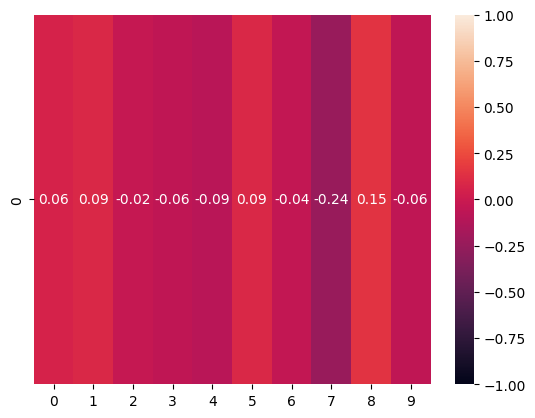

In [11]:
# Représentation des 10 premières valeurs pour plus de lisibilité
sb.heatmap(example_embedding.iloc[:,:10], vmin=-1.0, vmax=1.0, annot=True, fmt=".2f")


Il est aussi possible d’avoir un aperçu du vocabulaire d’un modèle dans son espace latent.

Pour cela, il nous faut d’abord recupérer les *embeddings* de chaque *token* présent dans le vocabulaire d’un modèle.

In [12]:
# On récupère le vocabulaire du modèle
vocab = [token.replace("▁", "") for token in list(bert_tokenizer.get_vocab().keys())]

# On encodage le vocabulaire
embedded_vocab = feature_extractor(vocab, batch_size=32)

# On met le résultat sous un format plus facile à utiliser
df_embedded_vocab = pd.DataFrame([np.array(ev[0]).mean(axis=0) for ev in embedded_vocab], index=vocab)

# On affiche le résultat
df_embedded_vocab

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
Magazine,0.051496,0.092337,-0.023806,-0.058914,-0.090273,0.083883,-0.042449,-0.240793,0.145990,-0.058473,...,0.060779,0.017424,-0.123024,0.284326,-0.124560,0.208022,0.095236,0.190477,-0.071948,0.211273
peser,0.050593,0.091539,-0.024743,-0.059164,-0.090969,0.083585,-0.040158,-0.240950,0.145224,-0.058104,...,0.061664,0.019199,-0.122165,0.283656,-0.122599,0.207997,0.094180,0.191095,-0.072992,0.211307
amorti,0.051589,0.092138,-0.024052,-0.058829,-0.090928,0.083720,-0.041493,-0.241076,0.145255,-0.058464,...,0.061869,0.018870,-0.122409,0.283921,-0.122984,0.207848,0.095526,0.190060,-0.072595,0.211841
album,0.052129,0.091408,-0.024209,-0.058385,-0.090897,0.083693,-0.041640,-0.242110,0.144735,-0.058419,...,0.062148,0.017793,-0.122840,0.283680,-0.122537,0.208398,0.095906,0.191057,-0.072381,0.211952
Vous,0.052320,0.090477,-0.024161,-0.057536,-0.091203,0.083586,-0.042768,-0.243107,0.143637,-0.058074,...,0.062585,0.017532,-0.122382,0.283598,-0.121813,0.208725,0.095952,0.190733,-0.073145,0.213033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
some,0.051548,0.091190,-0.023753,-0.057412,-0.091105,0.083859,-0.042077,-0.241331,0.144738,-0.057721,...,0.061543,0.017706,-0.122100,0.284149,-0.123932,0.208438,0.095482,0.190076,-0.072439,0.211467
réjoui,0.051179,0.090956,-0.024621,-0.058137,-0.091405,0.083944,-0.041003,-0.241600,0.144449,-0.057667,...,0.061999,0.019057,-0.121999,0.284031,-0.123617,0.208635,0.095876,0.189258,-0.073147,0.213072
gique,0.032607,0.270425,-0.077359,-0.156264,-0.054102,0.036350,-0.105100,-0.109252,0.149384,-0.108391,...,-0.012561,0.003214,-0.075649,0.163181,-0.021616,0.168167,-0.050741,0.186378,-0.033743,0.037271
informations,0.052099,0.091625,-0.023781,-0.058026,-0.090662,0.084134,-0.042111,-0.241682,0.145512,-0.058794,...,0.061078,0.016881,-0.123414,0.284176,-0.123847,0.208328,0.095479,0.190881,-0.071603,0.211237


On peut alors récupérer l’*embedding* d’un *token* specifique, par exemple:

In [13]:
df_embedded_vocab.loc[[example]]

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
fromage,0.052097,0.090172,-0.023933,-0.057959,-0.090701,0.083563,-0.041995,-0.242352,0.143963,-0.057947,...,0.062504,0.018199,-0.122351,0.283579,-0.122374,0.208417,0.095818,0.19029,-0.073104,0.213479


Il nous faut maintenant représenter ces *tokens* sur un plan en deux dimensions.

En d’autres termes, il nous faut réduire le nombre de dimensions de nos vecteurs
(ou *embeddings*) à 2.

Pour cela, nous allons utiliser l’algorithme *Principal Component Analysis* (PCA) disponible dans la librairie *scikit-learn*.

In [14]:
from sklearn.decomposition import PCA

Dans un premier temps, nous allons initialiser PCA et l’appliquer aux vecteurs correspondants au vocabulaire de notre modèle pour déterminer les deux dimensions à utiliser.

In [15]:
# On initialise PCA
pca = PCA(n_components=2)

# On applique PCA à nos embeddings
pca_embedded_vocab = pca.fit_transform(df_embedded_vocab)

# Et on mets le résultats sous un format plus facilement manipulable
df_pca = pd.DataFrame(data = pca_embedded_vocab, columns = ['PC1', 'PC2'], index=vocab)

Nous pouvons maintenant générer un graphe de points en deux dimensions dans lequel chaque point correspond à un *token*.

Pour cela nous utilisons les librairies *jscatter* et *ipywidgets* qui permettent de générer des graphes interactifs.

In [16]:
import jscatter
import ipywidgets

In [17]:
# Création du graphe
scatter = jscatter.Scatter(data=df_pca, x="PC1", y="PC2")

# Création du module interactif
output = ipywidgets.Output()

# Définition d'une fonction à appeler lors de la sélection de points
@output.capture(clear_output=True)
def selection_change_handler(change):
  display(df_pca.iloc[change.new])

# Connection de l'action de sélection de points à la fonction
scatter.widget.observe(selection_change_handler, names=["selection"])

# Affichage du graphe
ipywidgets.HBox([scatter.show(), output])

Pour d’autres exemples de visualisation d’espace latent, voir:

https://projector.tensorflow.org/

https://helboukkouri.github.io/embedding-visualization/

Chaque point d’un espace latent étant associé à un *token* et positionné les uns par rapport aux autres, il est donc théoriquement possible de calculer une "distance sémantique" entre deux *tokens*.

Pour cela, nous allons utiliser la [similarité cosinus](https://fr.wikipedia.org/wiki/Similarit%C3%A9_cosinus) disponible dans la librairie *scikit-learn*.

In [18]:
from sklearn.metrics.pairwise import cosine_similarity

La similarité cosinus se base sur l’angle formé par deux vecteurs de taille $n$ et fourni un score entre -1 et 1.

C’est une similarité généralement employée en TAL.

Nous allons donc l’employer ici pour trier le vocabulaire de notre modèle et trouver les *tokens* "proches" d’un *embedding* donné.

In [19]:
### Définition de la fonction de tri
def sort_vocab_by_similarity(embedding):
  # On calcule la similarite entre l'embedding fourni en entree
  # et les embeddings du vocabulaire de notre modèle
  cos_sim = cosine_similarity(embedding, df_embedded_vocab)

  # On met les résultats sous un format plus facilement manipulable
  df = pd.DataFrame(cos_sim[0], columns=["similarity"], index=vocab)

  # On tri par similarite avec l'embedding fourni en entree
  df = df.sort_values(by=['similarity'], ascending=False)

  # On retourne le résultat
  return df

Par exemple:

In [20]:
sort_vocab_by_similarity(df_embedded_vocab.loc[[example]])

,similarity
fromage,1.000000
légumes,0.999998
rate,0.999997
rate,0.999997
tomate,0.999997
...,...
amiante,0.103017
Himalaya,0.102952
homéopathie,0.095034
arthrose,0.078507


C’est cette méthode qui est employé sur des sites tels que:

https://cemantix.certitudes.org/

https://degaucheoudedroite.delemazure.fr/

Enfin, il est aussi possible d’effectuer des opérations mathématiques sur nos vecteurs.

Nous avons déjà vu que nous pouvons faire une moyenne de plusieurs *embeddings*, voyons maintenant ce qu’il se passe lorsque nous additionnons et soustrayons des *embeddings* entre eux.

In [21]:
mot1 = feature_extractor("France")
mot1 = pd.DataFrame([np.array(mot1[0]).mean(axis=0)])
mot1

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.055717,0.09041,-0.024223,-0.0574,-0.087523,0.087154,-0.041504,-0.236521,0.146783,-0.059964,...,0.059269,0.015206,-0.130222,0.284214,-0.123126,0.208591,0.099239,0.188696,-0.066105,0.21272


In [22]:
mot2 = feature_extractor("Camembert")
mot2 = pd.DataFrame([np.array(mot2[0]).mean(axis=0)])
mot2

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.062058,-0.195334,0.160326,0.05287,0.00986,0.141083,0.0753,-0.06337,-0.013757,0.17249,...,-0.10902,-0.28781,0.062174,-0.114293,0.051409,0.112685,0.066961,-0.230647,-0.176212,0.001969


In [23]:
mot3 = feature_extractor("Mozzarella")
mot3 = pd.DataFrame([np.array(mot3[0]).mean(axis=0)])
mot3

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.111452,0.188877,0.200548,-0.04093,-0.004627,-0.024595,-0.002886,-0.161723,0.072194,0.040703,...,-0.05356,0.008205,0.121587,0.016426,-0.06333,0.1248,-0.033965,0.180118,-0.066135,-0.047725


In [24]:
mot1 - mot2 + mot3

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.229228,0.474622,0.015999,-0.1512,-0.10201,-0.078524,-0.11969,-0.334873,0.232734,-0.191751,...,0.11473,0.31122,-0.070809,0.414933,-0.237866,0.220707,-0.001687,0.599461,0.043971,0.163026


In [25]:
sort_vocab_by_similarity(mot1 - mot2 + mot3)[:10]

,similarity
manif,0.626779
être,0.623142
divertissement,0.622971
sort,0.622724
sort,0.622724
émotions,0.622538
Alfa,0.622463
maths,0.622412
penser,0.622393
pétition,0.622376


C’est ce principe d’addition de "concept" qui est utilisé, par exemple, dans: https://neal.fun/infinite-craft/

Pour d’autres exemples employant d’autres modèles, voir: http://nlp.polytechnique.fr/word2vec

Avant de passer à la suite, nous allons libérer des éléments de la mémoire de notre session.

In [26]:
del embedded_vocab
del df_embedded_vocab
del vocab
del scatter
gc.collect()

61

Et, si vous souhaitez en savoir plus sur le fonctionnement des embeddings, voir: https://jalammar.github.io/illustrated-word2vec/

### 1.3 Sauvegarde et recherche sémantique de documents

Dans la section précédente, nous avons vu comment transformer des mots sous forme de vecteurs et comment manipuler ces vecteurs.

Nous allons maintenant voir comment utiliser ces méthodes pour manipuler des phrases et des textes plus complexes.

De la même manière qu’un mot, une phrase va être découpé en *tokens* et chaque *token* transformé en *embedding*.

In [27]:
pd.DataFrame(feature_extractor("J'aime le fromage")[0])

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.177204,-0.230553,-0.009189,-0.050601,-0.061401,-0.013524,-0.084818,-0.027671,0.058791,0.042531,...,-0.022019,-0.126219,-0.070665,0.148416,0.141399,0.223381,-0.058531,-0.042698,-0.126763,-0.065393
1,-0.159442,-0.234692,-0.004240,-0.039621,-0.060021,-0.017743,-0.081018,-0.011802,0.064511,0.033558,...,-0.022296,-0.134043,-0.088052,0.160222,0.143065,0.210367,-0.048259,-0.065962,-0.109435,-0.073588
2,-0.265615,-0.223346,0.102156,0.026734,-0.109403,-0.055268,-0.092264,-0.023411,0.122202,0.025994,...,-0.067279,-0.055479,-0.066421,0.124942,0.143222,0.149812,-0.042700,-0.127783,-0.071020,-0.057344
3,-0.172378,-0.263803,0.029326,-0.154284,-0.052755,-0.126315,-0.160641,0.067976,-0.081165,0.115474,...,-0.005760,-0.112275,0.041618,0.046125,0.305893,0.102481,0.001218,-0.021843,0.047356,-0.089843
4,-0.254191,-0.262093,0.018736,-0.119192,-0.012791,-0.062838,-0.159512,0.034477,-0.127410,-0.025462,...,-0.022040,-0.132294,-0.004856,0.141705,0.160935,0.176730,0.000844,-0.095412,-0.007210,-0.123549
5,-0.173834,-0.390897,0.164144,-0.084324,-0.032224,-0.013148,-0.041192,0.002573,-0.041697,0.044509,...,0.005981,-0.206027,-0.041703,0.202167,0.239917,0.169980,-0.075573,-0.006363,0.029725,-0.078341
6,-0.177536,-0.229511,-0.008032,-0.050588,-0.061596,-0.013998,-0.084471,-0.027669,0.058781,0.043362,...,-0.021615,-0.127601,-0.068943,0.147586,0.141021,0.222494,-0.060169,-0.041283,-0.127443,-0.066583


Bien qu’il existe plusieurs approches possibles, la méthode généralement employée pour transformer une phrase, un texte ou un document en un vecteur est simplement de faire la moyenne des *embeddings*.

Par exemple:

In [28]:
example1 = pd.DataFrame([feature_extractor("J'aime le fromage",return_tensors = "pt")[0].numpy().mean(axis=0)])
example1

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.197171,-0.262128,0.041843,-0.067411,-0.055742,-0.043262,-0.100559,0.002068,0.007716,0.039995,...,-0.022147,-0.127705,-0.042718,0.138738,0.182207,0.179321,-0.040453,-0.057335,-0.052113,-0.079234


In [29]:
example2 = pd.DataFrame([feature_extractor("Je déteste le fromage",return_tensors = "pt")[0].numpy().mean(axis=0)])
example2

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.206332,-0.253208,0.056358,-0.047334,-0.009812,-0.065324,-0.07526,-0.122918,0.010897,-0.071286,...,-0.047099,-0.22857,-0.098004,0.006269,0.151007,0.05032,-0.004709,-0.03605,-0.114441,-0.083598


In [30]:
example3 = pd.DataFrame([feature_extractor("Le fromage, c'est vraiment bon", return_tensors = "pt")[0].numpy().mean(axis=0)])
example3

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.13061,-0.217488,0.022437,-0.043762,-0.067146,-0.089538,0.067793,-0.075925,0.024979,-0.030945,...,-0.016446,-0.033794,-0.056544,0.088199,0.174105,0.16988,-0.057969,-0.076651,-0.044772,-0.158101


In [31]:
example4 = pd.DataFrame([feature_extractor("Le soleil brille sur la ville de Lyon aujourd'hui", return_tensors = "pt")[0].numpy().mean(axis=0)])
example4

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.185959,0.271387,0.164718,-0.005831,-0.035801,0.06286,0.005786,0.201952,-0.106258,0.06956,...,0.15532,0.03246,0.120029,-0.045451,-0.09143,0.051947,-0.00407,0.150898,0.00228,-0.004999


Et de la même manière que pour les mots, il est possible de calculer une "distance sémantique" entre différents textes.

In [32]:
cosine_similarity(example1, example2)

array([[0.7603849]], dtype=float32)

In [33]:
cosine_similarity(example1, example3)

array([[0.75840825]], dtype=float32)

In [34]:
cosine_similarity(example1, example4)

array([[-0.06128929]], dtype=float32)

En se basant sur ce principe, il est alors possible de stocker des textes et leurs *embeddings* afin de les retrouver en fonction de leur "similarité" avec une requête données.

Pour cela, il nous faut d’abord créer une fonction permettant de stocker des textes et leurs *embeddings*.

In [35]:
# On cree une liste d'embeddings vide
bdd_embeddings = pd.DataFrame(columns=example1.columns)

# On fait de meme pour stocker les textes
bdd_texts = []

def store_text_embeddings(text):
  # Au cas ou, on test si le texte n'existe pas deja
  if not text in bdd_texts:
    # On genere les embeddings
    embeddings = feature_extractor(text, return_tensors = "pt")[0].numpy().mean(axis=0)
    # On ajoute les embeddings a notre liste d'embeddings
    bdd_embeddings.loc[len(bdd_embeddings.index)] = embeddings
    # On ajoute notre texte a notre liste de textes
    bdd_texts.append(text)

On peut maintenant utiliser cette fonction pour stocker en mémoire différents textes.

Par exemple:

In [36]:
texts = [
"Camembert est une appellation générique qui désigne généralement un fromage à pâte molle et à croûte fleurie. Commercialement, cette appellation d'origine normande ne fait l'objet d'aucune protection et se voit utilisée pour des fromages n'ayant parfois que peu de rapport avec le camembert originel. Dans certaines régions de France, le camembert est appelé « claquos », « clacos », « calendos ».",
"Le bleu d’Auvergne est un fromage à pâte persillée fabriqué en France dans le Massif central à partir de lait de vache. Son persillage allant du bleu au bleu noir. Son appellation d'origine bénéficie de protections depuis 1975.",
"La tomme de Savoie est un fromage produit en France dans la région alpine de Savoie, regroupant les départements de la Savoie et de la Haute-Savoie. Son appellation est protégée par une indication géographique protégée.",
"Le munster ou munster-géromé (ou encore Minschterkäs en francique lorrain ou Minschterkaas en alsacien) est un fromage à pâte molle fabriqué à partir de lait de vache dans l'Est de la France. Son appellation est protégée nationalement depuis 1969 par une appellation d'origine contrôlée (AOC) et dans l'ensemble des pays de l'Union européenne depuis 1996 par une appellation d'origine protégée (AOP).",
"Les bries sont une famille de fromages à pâte molle à croûte fleurie, originaire de la région française de Brie.",
"L’emmentaler ou emmental est un fromage d'origine suisse à pâte dure dont le nom provient de la vallée de l'Emme (en allemand, Emmental), une région à l'est du canton de Berne.",
"Beaufort (/bofɔːʁ/) est l'appellation d'origine d'un fromage au lait cru de vache, à pâte pressée cuite, élaboré en Savoie en France. La production du lait et sa transformation s'effectuent dans une aire comprenant la région du Beaufortain d'où il tire son nom. Il est formé en meule à talon légèrement concave. L'appellation beaufort est préservée commercialement via une Appellation d'origine protégée.",
"Le gorgonzola est l'appellation d'origine d'un fromage traditionnel à base de lait de vache, à pâte persillée, fabriqué dans les régions de Lombardie et du Piémont.",
"Le Valençay est une appellation d'origine désignant un fromage de chèvre au lait cru du Berry, et de la région Centre-Val de Loire, en France. Elle reprend le nom de la commune homonyme.",
"Le saint-marcellin IGP est un fromage français du Dauphiné. Son Indication géographique protégée (IGP) date de la fin 2013, elle s'étend sur 274 communes en Isère, dans la Drôme et en Savoie.",
"Reblochon ou reblochon de Savoie est une appellation d'origine désignant un fromage français produit principalement en Haute-Savoie et dans quelques communes de Savoie. Cette appellation est originaire du massif des Bornes et des Aravis, principalement la vallée de Thônes, et s'est étendue au val d'Arly et au massif des Bauges.",
"Comté est l'appellation d'origine d'un fromage français transformé principalement en Franche-Comté et bénéficiant d'une AOC depuis 1958 et d'une AOP depuis 1996. Son aire de production s'étend dans les départements du Jura, du Doubs, et de l'est de l'Ain. Elle englobe également une commune de Haute-Savoie et quelques-unes de Saône-et-Loire."
]

for text in texts:
  store_text_embeddings(text)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Si on affiche nos listes de textes et d’*embeddings*, on voit que les textes et leurs *embeddings* de la cellule précédente ont bien été enregistrés.

In [37]:
bdd_texts

["Camembert est une appellation générique qui désigne généralement un fromage à pâte molle et à croûte fleurie. Commercialement, cette appellation d'origine normande ne fait l'objet d'aucune protection et se voit utilisée pour des fromages n'ayant parfois que peu de rapport avec le camembert originel. Dans certaines régions de France, le camembert est appelé « claquos », « clacos », « calendos ».",
 "Le bleu d’Auvergne est un fromage à pâte persillée fabriqué en France dans le Massif central à partir de lait de vache. Son persillage allant du bleu au bleu noir. Son appellation d'origine bénéficie de protections depuis 1975.",
 'La tomme de Savoie est un fromage produit en France dans la région alpine de Savoie, regroupant les départements de la Savoie et de la Haute-Savoie. Son appellation est protégée par une indication géographique protégée.',
 "Le munster ou munster-géromé (ou encore Minschterkäs en francique lorrain ou Minschterkaas en alsacien) est un fromage à pâte molle fabriqué

In [38]:
bdd_embeddings

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.074783,0.085016,-0.062868,0.097638,0.036786,-0.050031,-0.000111,0.034756,-0.062347,0.057401,...,0.007117,0.012568,-0.017635,-0.006658,-0.101034,0.076232,-0.088443,-0.033654,0.006597,-0.048205
1,0.063421,0.253613,-0.120200,0.117762,0.074100,0.035653,-0.047618,-0.102907,-0.042858,-0.006137,...,-0.049471,0.037972,-0.073870,0.061039,-0.116328,0.161264,0.000680,0.111717,0.007406,-0.072680
2,0.049517,0.194520,-0.074837,0.108149,0.029408,-0.077933,0.022075,-0.151448,-0.072557,0.078556,...,-0.028678,0.052555,-0.094521,0.061995,-0.085052,0.196497,-0.147016,-0.074053,-0.022693,0.058121
3,0.164450,0.015129,-0.111291,0.079916,0.045138,0.022263,0.037492,-0.052073,-0.088665,0.024174,...,-0.053429,0.068386,-0.088297,-0.188339,-0.064867,0.161811,0.039624,-0.005834,0.055864,-0.039935
4,0.107579,0.098737,0.149081,0.088385,0.022124,-0.109033,-0.039909,-0.054505,0.152086,0.076036,...,0.077878,0.146978,0.037575,-0.038745,0.026293,0.102035,-0.117757,-0.021607,-0.027443,-0.107479
5,0.053637,-0.078943,0.069474,0.048112,0.014239,-0.115535,0.098122,-0.104459,-0.070823,-0.018865,...,-0.080427,0.162278,-0.115286,0.065139,0.007262,0.093029,0.010597,0.050752,-0.016226,-0.115248
6,0.077710,0.128620,-0.055370,0.100762,-0.007400,-0.100944,-0.006179,-0.102276,0.003237,-0.062342,...,-0.010625,0.087201,-0.031469,0.014341,-0.018566,0.142330,-0.114887,0.027101,0.071191,0.050712
7,0.051147,0.007608,-0.013690,0.120262,0.127004,-0.029189,0.024637,-0.181737,-0.085504,0.022079,...,-0.023355,0.035727,-0.060390,0.049314,-0.073430,0.212517,-0.021598,0.016831,0.056931,-0.154337
8,0.069201,0.051432,0.026494,0.052797,0.093730,-0.034831,-0.056726,-0.015017,-0.060713,0.004185,...,-0.032855,0.119790,-0.000144,0.001639,-0.132179,0.171769,-0.191999,-0.028933,0.036037,-0.082979
9,0.083381,0.222816,-0.071599,0.108713,0.046623,0.015422,-0.048435,0.004663,-0.085091,0.033883,...,-0.069476,0.091205,0.045393,0.101188,-0.237243,0.246301,-0.090773,0.025345,-0.035923,0.019360


Ensuite, il nous faut créer une fonction permettant de rechercher dans ces *embeddings* pour trouver les documents stockés les plus "similaires" à une requête.

In [39]:
def find_embedded_texts(query, nresults=5):
  # On genere l'embedding correspondant a la requete
  query_embeddings = pd.DataFrame([feature_extractor(query, return_tensors = "pt")[0].numpy().mean(axis=0)])

  # On calcule la distance entre l'embedding de la requete et les embeddings stockes dans notre liste
  df = pd.DataFrame(cosine_similarity(query_embeddings, bdd_embeddings)[0], columns=["similarity"])

  # On tri par similarite
  df = df.sort_values(by=['similarity'], ascending=False)

  # On recupere les indices des premiers resultats
  indexes = df.iloc[:nresults].index

  # On recupere les textes correspondants
  results = []
  for i in indexes:
    results.append({"doc": bdd_texts[i], "score": df.loc[i]["similarity"]})

  # On retourne les textes et leurs scores de similarite
  return results

À l’aide de cette fonction, nous pouvons maintenant rechercher parmis les textes stockées ceux qui correspondent à une requête.

Par exemple:

In [40]:
query = """
Fromage de Savoie
"""

find_embedded_texts(query)

[{'doc': 'La tomme de Savoie est un fromage produit en France dans la région alpine de Savoie, regroupant les départements de la Savoie et de la Haute-Savoie. Son appellation est protégée par une indication géographique protégée.',
  'score': 0.5449897},
 {'doc': "Reblochon ou reblochon de Savoie est une appellation d'origine désignant un fromage français produit principalement en Haute-Savoie et dans quelques communes de Savoie. Cette appellation est originaire du massif des Bornes et des Aravis, principalement la vallée de Thônes, et s'est étendue au val d'Arly et au massif des Bauges.",
  'score': 0.4345962},
 {'doc': "Beaufort (/bofɔːʁ/) est l'appellation d'origine d'un fromage au lait cru de vache, à pâte pressée cuite, élaboré en Savoie en France. La production du lait et sa transformation s'effectuent dans une aire comprenant la région du Beaufortain d'où il tire son nom. Il est formé en meule à talon légèrement concave. L'appellation beaufort est préservée commercialement via u

Ici, pour un objectif pédagogique, nous avons codé nous même le fonctionnement d’une base de données utilisant les *embeddings*.

Il existe cependant des librairies python, telle que [chroma](https://www.trychroma.com/), qui permettent de gérer plus efficacement de telles bases de données.

## Partie 2 - Large modèles de langage et génération de texte

Dans cette partie, nous allons aborder l’aspect "decodage" des transformers.

Cet aspect est généralement employé pour générer du texte et est la base des large modèles de langage (LLM) tels que GPT-4, Mistral, ou encore LLaMA.

Pour cet atelier, nous allons utiliser le modèle [Phi-3](https://azure.microsoft.com/en-us/blog/introducing-phi-3-redefining-whats-possible-with-slms/). Un modèle proposé par Microsoft, qui a l’avantage d’être assez léger et sous licence libre (MIT).

Afin de charger ce modèle, nous allons utiliser la classe *AutoModelForCausalLM* de la librairie *transformers* comme suit.

In [41]:
from transformers import AutoModelForCausalLM

In [42]:
llm_model_name = "microsoft/Phi-3-mini-128k-instruct"

llm_model = AutoModelForCausalLM.from_pretrained(llm_model_name, device_map=device, torch_dtype="auto", trust_remote_code=True)
llm_tokenizer = AutoTokenizer.from_pretrained(llm_model_name)


config.json:   0%|          | 0.00/3.48k [00:00<?, ?B/s]

configuration_phi3.py:   0%|          | 0.00/11.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-128k-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py:   0%|          | 0.00/73.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-128k-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.44k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

Si vous souhaitez utiliser un autre modèle, voir: https://huggingface.co/models?pipeline_tag=text-generation.

### 2.1 Complétion de texte

L’objectif de base de la partie decodage d’un transformer est la complétion de texte.

En d’autres termes, pour un texte données, un llm va chercher à déterminer le *token* pouvant le plus plausiblement faire suite à ce texte.

Pour ce faire, nous allons créer un nouveau pipeline permettant de gérérer du texte à partir de notre llm.

In [43]:
text_generator = pipeline(
    "text-generation",
    model=llm_model,
    tokenizer=llm_tokenizer,
)

Device set to use cuda:0


Nous pouvons alors lui demander de compléter un texte.

Par exemple:

In [44]:
prompt = "Le fromage c'est vraiment bon, surtout le"

Pour ce faire, notre llm va décomposer la phrase en *tokens* puis en *embeddings* comme vu en Partie 1.

Puis il va déterminer, parmis les *tokens* de son vocabulaire, lesquels sont les plus "plausible" pour faire suite aux tokens composant le texte fourni en entrée.

In [45]:
output = text_generator(prompt, max_new_tokens = 1, return_full_text = False, do_sample = True, num_return_sequences=5)
print(output)

The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
`get_max_cache()` is deprecated for all Cache classes. Use `get_max_cache_shape()` instead. Calling `get_max_cache()` will raise error from v4.48


[{'generated_text': ' cam'}, {'generated_text': ' cam'}, {'generated_text': ' from'}, {'generated_text': ' br'}, {'generated_text': ' Br'}]


Parmis ces *tokens*, notre llm va prend le plus "plausible", puis l’ajouter aux texte fournit en entrée pour déterminer le *token* suivant.

Ainsi de suite, jusqu’à atteindre la longueur souhaitée.

In [46]:
output = text_generator(prompt, max_new_tokens = 5, return_full_text = False)
print(output[0]["generated_text"])

 camembert.



Il est aussi possible de pousser le llm à sélectioner des *tokens* qui seraient moins "plausible", de manière plus aléatoire.

Pour cela, il suffit de lui fournir une "temperature". Plus cette "temperature" est élevée, plus le llm cherchera des *tokens* moins plausible.

In [47]:
output = text_generator(prompt, max_new_tokens= 5, return_full_text = False, do_sample=True, temperature = float(SEED) / 50.0, num_return_sequences=3)
print(output)

[{'generated_text': ' camembert. J'}, {'generated_text': ' camembert. On'}, {'generated_text': ' camembert. C'}]


### 2.2 Agents Conversationnels (ChatBot)

La complétion de texte, que nous avons vu en section 2.1, est la base des agents conversationnels, ou ChatBot, tels que [ChatGPT](https://chatgpt.com/), [Copilot](https://www.bing.com/chat?q=Microsoft+Copilot&FORM=hpcodx) ou encore [ChatCGT](https://chatcgt.fr/).

Néanmoins, afin d’optimiser cette complétion dans le cadre d’un ChatBot, les modèles employés sont entrainé sur des textes tournés sous forme de conversations ou "instructions".

C’est le cas du modèle que nous utilisons. D’ailleurs, si vous augmentez la taille des textes générés dans l’example précédent, notre llm devrait générer une conversation.

Afin d’utiliser notre llm dans un ChatBot, il nous donc saisir notre requête en précisant que c’est le texte saisie par l’utilisateur.

Par exemple:

In [48]:
query = "J'aimerais manger un fromage de Savoie, que me conseille tu ?"

messages = [
    {"role": "user", "content": query},
]

In [49]:
output = text_generator(messages, return_full_text = False, max_new_tokens = 500)
print(output[0]['generated_text'])

 Pour profiter de la gastronomie savoyarde, je vous conseille de goûter le Comté, un fromage traditionnel de la région. Le Comté est un fromage à pâte pressée cuite, avec une croûte fleurie et un fond fondant. Il est fabriqué à partir de lait de vache de race abondance et a une saveur riche et complexe. Vous pouvez le déguster en tranches avec des pains spéciaux de la région, comme le pain de seigle ou le pain de campagne, ou en fondant pour accompagner des fromages blancs ou des pâtisseries. Assurez-vous de le goûter dans un fromagerie locale pour apprécier son authenticité et sa qualité.


Cependant, notre llm ne garde pas en mémoire le contexte de la conversation et les questions déjà posées.

Pour poursuivre cette conversation, il nous faut donc ajouter les réponses du ChatBot aux messages pré-existant avant de poser une nouvelle question.

Par exemple:

In [50]:
messages.append({"role": "assistant", "content": output[0]['generated_text']})
messages.append({"role": "user", "content": "Je cherche un fromage plus insolite"})
messages

[{'role': 'user',
  'content': "J'aimerais manger un fromage de Savoie, que me conseille tu ?"},
 {'role': 'assistant',
  'content': ' Pour profiter de la gastronomie savoyarde, je vous conseille de goûter le Comté, un fromage traditionnel de la région. Le Comté est un fromage à pâte pressée cuite, avec une croûte fleurie et un fond fondant. Il est fabriqué à partir de lait de vache de race abondance et a une saveur riche et complexe. Vous pouvez le déguster en tranches avec des pains spéciaux de la région, comme le pain de seigle ou le pain de campagne, ou en fondant pour accompagner des fromages blancs ou des pâtisseries. Assurez-vous de le goûter dans un fromagerie locale pour apprécier son authenticité et sa qualité.'},
 {'role': 'user', 'content': 'Je cherche un fromage plus insolite'}]

In [51]:
output = text_generator(messages, return_full_text = False, max_new_tokens = 500)
print(output[0]['generated_text'])

 Pour découvrir un fromage insolite, je vous recommande de goûter au Reblochon, un fromage de la région Auvergne-Rhône-Alpes, mais avec une touche d'originalité. Le Reblochon est un fromage à pâte molle à croûte fleurie, fabriqué à partir de lait cru de vache de race abondance. Ce fromage est célèbre pour sa texture crémeuse et son goût riche, avec une saveur caractéristique de fromage à la crème et aux notes de noisette. Pour une expérience unique, essayez de le déguster avec des pommes de terre cuites au four, un accompagnement traditionnel qui met en valeur la douceur du Reblochon. Vous pouvez également le servir en fondant pour créer une sauce réconfortante pour des pâtes ou des légumes. Pour une option encore plus originale, préparez un gratin de Reblochon avec des légumes de saison et des herbes fraîches pour une touche gourmande et une expérience culinaire inoubliable.


À partir de là, nous avons les éléments pour créer un ChatBot minimal.

Tout d’abord, nous allons créer un message qui va initialiser le ChatBot avec ce qui est attendu de lui. Ce message initial est aussi appelé *pre-prompt*.


In [52]:
pre_prompt = """
Tu es un ChatBot spécialisé en fromages.
L'utilisateur est un amateur de fromages de longue date et il connait lui aussi de nombreux fromages.
Ton objectif est de lui faire découvrir des fromages peu connu et insolites en fonction de ses demandes.
Acceuille le avec un message de bienvenu et en te presentant.
"""

messages = [
    {
        "role": "user",
        "content": pre_prompt
    }
]

Ensuite, nous allons définir les paramètres généraux à utiliser lors de la génération de textes par le ChatBot.

In [53]:
generation_args = {
    "max_new_tokens": 500,
    "return_full_text": False,
    "do_sample": False,
    # pour utiliser le paramètre "temperature", passer le paramètre "do_sample" à True
    #"temperature": float(SEED)
}

Et enfin, nous pouvons lancer une boucle qui génére un message du ChatBot, attends un message de l’utilisateur et complète automatiquement la conversation.

La conversation s’arrête lorsque l’utilisateur saisi le mot "fin".

In [57]:
usr_input = ""
while usr_input != "fin":
  # On genere un message du ChatBot
  output = text_generator(messages, **generation_args)

  # On affiche le message
  print("\nChatBot:", output[0]['generated_text'], "\n")

  # On attend l'entree de l'utilisateur
  usr_input = input("Utilisateur:")

  # On met à jour la conversation
  messages.append({"role": "assistant", "content": output[0]['generated_text']})
  messages.append({"role": "user", "content": usr_input})


KeyboardInterrupt: 

### 2.3 Techniques d’instructions (Prompt Engineering)

Avant de clôre cette partie, nous allons aborder différentes techniques, issues du domaine du *Prompt Engineering*, permettant d’optimiser et maximiser la qualité des réponses fournies par un ChatBot.

Parmis ces techniques, une très simple à employer est celle de la chaîne de pensées, ou *Chain of Thoughts* (CoT) en anglais.

Pour utiliser cette technique, il suffit d’ajouter "Pensons étape par étape" (*Let's think step by step*) ou "Détaille ta réponse" à notre requête.

Cela forcera la probabilité que le ChatBot génère un texte avec plusieurs étapes, avec un contenu plus détaillé et donc une réponse de meilleure qualité.

Pour en savoir plus, voir: https://www.promptingguide.ai/techniques/cot

In [55]:
messages = [
    {
        "role": "user",
        "content":
        """
          Détaille ta réponse étape par étape.
        """ + query
     }
]

In [56]:
output = text_generator(messages, **generation_args)
print(output[0]['generated_text'])

 Pour répondre à votre demande étape par étape, voici une suggestion détaillée pour manger un fromage de Savoie :

1. Recherche des fromages de Savoie : Commencez par rechercher les fromages de Savoie les plus renommés et appréciés. Certains des plus célèbres incluent le Reblochon, le Tomme de Savoie, le Comté, et le Beaufort.

2. Choisir un fromage : Après avoir fait votre recherche, choisissez un fromage qui vous plaît le plus. Par exemple, vous pourriez choisir le Reblochon pour sa texture crémeuse et son goût riche.

3. Trouver un fromager ou un magasin spécialisé : Recherchez un fromager local ou un magasin spécialisé dans les produits de la région Savoie pour acheter votre fromage. Cela vous permettra d'apprécier le fromage dans son contexte local et de soutenir l'économie locale.

4. Planifier une visite : Si possible, planifiez une visite à la région Savoie pour profiter de la beauté naturelle de la région et pour découvrir d'autres produits locaux, tels que les vins, les pains

Cependant, la plupart des llm sont maintenant entrainé pour utiliser automatiquement du CoT lors de la génération de leurs réponses.

Une autre technique possible, dérivée de CoT, est l’arbre de pensées, ou *Tree of Thoughts* (ToT) en anglais.

Cette technique reprends le principe de CoT, mais détaillant étape par étape des réponses selon différents point de vue et en comparant ces réponses entre elles.

Pour en savoir plus, voir: https://www.promptingguide.ai/techniques/tot

In [58]:
messages = [
    {
        "role": "user",
        "content":
        """
          Imagine que trois experts différents débattent pour répondre à cette question.
          Chaque expert écrit une étape de sa réflexion et la partage avec le groupe.
          Puis tous les experts continue ainsi de suite, étape par étape.
          Si un expert réalise qu'il s'est trompé à un moment de sa réflexion, il sort de la discussion.
          La question est:
        """ + query
     }
]

In [59]:
generation_args["max_new_tokens"] = 5000

In [60]:
output = text_generator(messages, **generation_args)
print(output[0]['generated_text'])

 Expert 1:

Première étape de réflexion : Je commence par identifier les fromages de Savoie les plus célèbres et appréciés.

Deuxième étape de réflexion : Je vais ensuite rechercher des fromages de Savoie qui sont disponibles dans les magasins locaux ou en ligne.

Troisième étape de réflexion : Je vais ensuite prendre en compte les préférences personnelles du consommateur, comme le goût, la texture et la compatibilité avec d'autres plats.

Quatrième étape de réflexion : Je vais finalement recommander un fromage de Savoie qui correspond aux critères identifiés et qui est également accessible pour le consommateur.

Expert 2:

Première étape de réflexion : Je commence par rechercher les fromages de Savoie les plus réputés et les plus appréciés à l'échelle internationale.

Deuxième étape de réflexion : Je vais ensuite chercher des sources fiables pour obtenir des informations sur les fromages de Savoie disponibles dans les magasins locaux ou en ligne.

Troisième étape de réflexion : Je vai

Enfin, il est aussi possible de demander au ChatBot de générer des connaissances générales en lien avec la question posée.

Cette technique, appellée *Generated Knowledge Prompting*, guide alors la génération de texte à l’aide de ces connaissances fourni explicitement.

Pour en savoir plus, voir: https://www.promptingguide.ai/techniques/knowledge

In [61]:
messages = [
    {
        "role": "user",
        "content":
        """
          Avant de répondre à la question, écrit les différentes connaissances que tu as sur le sujet.
          La question est:
        """ + query
     }
]

In [62]:
output = text_generator(messages, **generation_args)
print(output[0]['generated_text'])

 Je suis spécialisé dans la fourniture d'informations et de recommandations basées sur des données et des connaissances existantes. Voici ce que je sais sur le fromage de Savoie :

Le fromage de Savoie est un fromage français originaire de la région de Savoie, en France. Il est fabriqué à partir de lait de vache et est connu pour sa texture crémeuse et son goût riche. Il existe plusieurs variétés de fromage de Savoie, chacune avec ses propres caractéristiques et saveurs.

Les principales variétés de fromage de Savoie sont :

1. Le Reblochon : Il s'agit d'un fromage à pâte persillée, avec une croûte brunâtre et une texture crémeuse. Il a une saveur riche et un goût de fromage fort.

2. Le Tomme de Savoie : Il s'agit d'un fromage à pâte molle, avec une croûte naturelle et une texture crémeuse. Il a une saveur douce et légèrement acidulée.

3. Le Comté : Bien que ce ne soit pas un fromage de Savoie, le Comté est un fromage français proche du fromage de Savoie. Il est fabriqué à partir de 

Bien entendu, ces différentes techniques ne sont pas mutuellement exclusives et pouvent se combiner entre elles.

Par exemple:

In [63]:
messages = [
    {
        "role": "user",
        "content":
        """
          Imagine que trois experts différents débattent pour répondre à cette question.
          Chaque expert a des connaissances différentes des autres sur le sujet.
          Avant de débattre, chaque expert énonce ses connaissances sur le sujet.
          Ensuite, chaque expert écrit une étape de sa réflexion et la partage avec le groupe.
          Chaque expert peut réfuter les arguments d'un autre expert.
          Si un expert réalise qu'il s'est trompé à un moment de sa réflexion, il sort de la discussion.
          Ainsi de suite jusqu'à arriver à un consensus apportant une réponse à la question.
          La question est: "Je cherche un fromage de Savoie, que me conseille-tu?"
        """
     }
]

In [64]:
output = text_generator(messages, **generation_args)
print(output[0]['generated_text'])

 Expert 1 (fromage de lacs): Je suis spécialiste des fromages de lacs, et je vous conseille le Reblochon, un fromage à pâte molle à croûte lavée qui est fabriqué dans la région des lacs de Savoie. Il a une texture crémeuse et un goût riche en fromage.


Étape de réflexion de l'Expert 1:

1. Recherche des fromages de lacs dans la région de Savoie.

2. Sélection du Reblochon en raison de sa réputation et de sa qualité.

3. Considération de la disponibilité du Reblochon dans les magasins locaux ou en ligne.


Expert 2 (fromage de lave): Je suis spécialiste des fromages de lave, et je vous recommande le Tomme de Savoie, un fromage à pâte pressée cuite qui est fabriqué à partir de lait de vache et de lait de brebis. Il a une texture ferme et un goût doux et légèrement herbacé.


Étape de réflexion de l'Expert 2:

1. Recherche des fromages de lave dans la région de Savoie.

2. Sélection du Tomme de Savoie en raison de sa popularité et de sa disponibilité.

3. Considération de la texture et d

De nombreuses autres techniques de *Prompt Engineering* existent, telles que [Self-Consistency](https://www.promptingguide.ai/techniques/consistency) ou [ReAct](https://www.promptingguide.ai/techniques/react), et bien d’autres vont surement voir le jour dans les prochaines années.

L’objectif étant alors de trouver les bonnes formulations pour répondre le plus efficacement à telle ou telle demande. Des techniques comme l’[APE](https://www.promptingguide.ai/techniques/ape) pour *Automatic Prompt Engineer* propose même de générer ces formulations via un modèle de langage.

Pour aller plus loin sur le sujet, voir: https://www.promptingguide.ai/

## Partie 3 - Combiner encodage et décodage avec les LLM Agents

Pour conclure cet atelier, nous allons voir dans cette partie comment créer un assistant personnel minimal en combinant les différentes techniques et méthodes vues dans les partie précédentes.

### 3.1 Generation augmentée par requêtes (RAG)

La géneration augmentée par requêtes, ou *Retrieval Augmented Generation* (RAG) en anglais, est une technique de *Prompt Engineering* consistant à compléter une question avec des informations vérifiées et stockées en base.

Nous pouvons, par exemple, réutiliser la fonction créée en partie 1 afin de retrouver des documents correspondants à notre requête.

In [65]:
docs = find_embedded_texts(query)
docs

[{'doc': 'La tomme de Savoie est un fromage produit en France dans la région alpine de Savoie, regroupant les départements de la Savoie et de la Haute-Savoie. Son appellation est protégée par une indication géographique protégée.',
  'score': 0.5402258},
 {'doc': "Reblochon ou reblochon de Savoie est une appellation d'origine désignant un fromage français produit principalement en Haute-Savoie et dans quelques communes de Savoie. Cette appellation est originaire du massif des Bornes et des Aravis, principalement la vallée de Thônes, et s'est étendue au val d'Arly et au massif des Bauges.",
  'score': 0.44394603},
 {'doc': "Beaufort (/bofɔːʁ/) est l'appellation d'origine d'un fromage au lait cru de vache, à pâte pressée cuite, élaboré en Savoie en France. La production du lait et sa transformation s'effectuent dans une aire comprenant la région du Beaufortain d'où il tire son nom. Il est formé en meule à talon légèrement concave. L'appellation beaufort est préservée commercialement via 

Ensuite, il nous faut créer une nouvelle requête complétant la première avec les informations retrouvées et indiquant à notre llm d’utiliser ses informations.

In [66]:
usr_input = "Pour répondre à la question base toi sur les informations suivantes, en indiquant les informations utilisées et comment:"

for i, doc in enumerate(docs):
  usr_input += "\n\nInformation " + str(i) + ": \"" + doc["doc"] + "\""

usr_input += "\n\nla question est: \"" + query + "\""

print(usr_input)

Pour répondre à la question base toi sur les informations suivantes, en indiquant les informations utilisées et comment:

Information 0: "La tomme de Savoie est un fromage produit en France dans la région alpine de Savoie, regroupant les départements de la Savoie et de la Haute-Savoie. Son appellation est protégée par une indication géographique protégée."

Information 1: "Reblochon ou reblochon de Savoie est une appellation d'origine désignant un fromage français produit principalement en Haute-Savoie et dans quelques communes de Savoie. Cette appellation est originaire du massif des Bornes et des Aravis, principalement la vallée de Thônes, et s'est étendue au val d'Arly et au massif des Bauges."

Information 2: "Beaufort (/bofɔːʁ/) est l'appellation d'origine d'un fromage au lait cru de vache, à pâte pressée cuite, élaboré en Savoie en France. La production du lait et sa transformation s'effectuent dans une aire comprenant la région du Beaufortain d'où il tire son nom. Il est formé e

Nous pouvons alors fournir cette nouvelle requête à notre llm, qui devrait générer une réponse basée sur les informations que nous avons retrouvées en base.

In [67]:
messages = [
    {
        "role": "user",
        "content": usr_input
     }
]

output = text_generator(messages, return_full_text = False, max_new_tokens=500)
print(output[0]['generated_text'])

 Pour répondre à la question, je vous conseille de goûter au Reblochon ou au Beaufort. Ces deux fromages sont originaires de la région de Savoie, conformément à la demande de choisir un fromage de Savoie.

Information utilisée: Information 0 et Information 1.

Explication: Le Reblochon est un fromage produit principalement en Haute-Savoie et dans quelques communes de Savoie, comme indiqué dans l'Information 1. De plus, l'Information 0 mentionne que la tomme de Savoie est un fromage produit en Savoie, ce qui confirme que le Reblochon est un bon choix pour un fromage de Savoie.

Le Beaufort est un autre fromage de Savoie, comme mentionné dans l'Information 2. Il est élaboré en Savoie et a une appellation d'origine protégée, ce qui en fait un choix sûr et de qualité pour un fromage de Savoie.

En résumé, le Reblochon et le Beaufort sont deux bons choix pour un fromage de Savoie, car ils sont tous deux originaires de la région et ont une appellation d'origine protégée.


Pour en savoir plus sur le RAG, voir: https://www.promptingguide.ai/techniques/rag

### 3.2 Utilisation d’outils

Il est aussi possible d’indiquer au llm les fonctions, aussi appellé outils ou *tools*, qu’il peut utiliser pour répondre aux requêtes d’un utilisateur, cela afin d’automatiser leur utilisation.

Pour cela, il nous faut lui fournir un *prompt* avec les instructions nécessaires.

Par exemple:

In [68]:
messages = [
    {
        "role": "user",
        "content":
          """
            Pour répondre à la question, utilise la fonction "find_embedded_texts" et base toi sur ses résultats en indiquant quelle information tu as utilisé et comment.

            Pour utiliser cette fonction, écrit uniquement et simplement son nom et ses arguments, comme suit:

            {"name": "find_embedded_texts", "args": {"query": "question de l'utilisateur"}}

            La question est:
          """ + query
    }
]

Ce *prompt* permet d’aiguiller la génération de texte afin que le llm écrive la fonction à appeler.

In [76]:
generated_text = text_generator(messages, return_full_text = False, max_new_tokens=500)[0]['generated_text']
print(generated_text)

 ```json

{

  "name": "find_embedded_texts",

  "args": {

    "query": "J'aimerais manger un fromage de Savoie, que me conseille tu?"

  }

}

```


Pour répondre à cette question, j'ai utilisé la fonction `find_embedded_texts` avec le texte de la question de l'utilisateur comme argument. Cette fonction est censée rechercher des informations ou des suggestions pertinentes dans un corpus de texte qui pourrait inclure des recettes, des critiques de fromages, des recommandations de restaurants, etc. Les résultats de cette fonction aideraient à identifier des sources fiables et pertinentes pour conseiller un fromage de Savoie à l'utilisateur.


Il nous faut alors récupérer les éléments pour appeler la fonction.

In [80]:
function_called = json.loads(re.findall(r'\{[\s\r\n]*\"name\": \"find_embedded_texts\",[\s\r\n]*\"args\": \{[\s\r\n]*.+[\s\r\n]*\}[\s\r\n]*\}', generated_text)[0])
function_called

{'name': 'find_embedded_texts',
 'args': {'query': "J'aimerais manger un fromage de Savoie, que me conseille tu?"}}

Pour ensuite appeler la fonction avec les arguments générés par le llm.

In [81]:
docs = find_embedded_texts(function_called["args"]["query"])
docs

[{'doc': 'La tomme de Savoie est un fromage produit en France dans la région alpine de Savoie, regroupant les départements de la Savoie et de la Haute-Savoie. Son appellation est protégée par une indication géographique protégée.',
  'score': 0.53740823},
 {'doc': "Reblochon ou reblochon de Savoie est une appellation d'origine désignant un fromage français produit principalement en Haute-Savoie et dans quelques communes de Savoie. Cette appellation est originaire du massif des Bornes et des Aravis, principalement la vallée de Thônes, et s'est étendue au val d'Arly et au massif des Bauges.",
  'score': 0.43934757},
 {'doc': "Beaufort (/bofɔːʁ/) est l'appellation d'origine d'un fromage au lait cru de vache, à pâte pressée cuite, élaboré en Savoie en France. La production du lait et sa transformation s'effectuent dans une aire comprenant la région du Beaufortain d'où il tire son nom. Il est formé en meule à talon légèrement concave. L'appellation beaufort est préservée commercialement via

Puis compléter la discussion avec les résultats de la recherche.

In [82]:
system_text = "Résultats de la fonction:"

for i, doc in enumerate(docs):
  system_text += "\n\nInformation " + str(i) + ": \"" + doc["doc"] + "\""

messages.append({"role": "assistant", "content": generated_text})
messages.append({"role": "user", "content": system_text})

messages

[{'role': 'user',
  'content': '\n            Pour répondre à la question, utilise la fonction "find_embedded_texts" et base toi sur ses résultats en indiquant quelle information tu as utilisé et comment.\n\n            Pour utiliser cette fonction, écrit uniquement et simplement son nom et ses arguments, comme suit:\n\n            {"name": "find_embedded_texts", "args": {"query": "question de l\'utilisateur"}}\n\n            La question est:\n          J\'aimerais manger un fromage de Savoie, que me conseille tu ?'},
 {'role': 'assistant',
  'content': ' ```json\n\n{\n\n  "name": "find_embedded_texts",\n\n  "args": {\n\n    "query": "J\'aimerais manger un fromage de Savoie, que me conseille tu?"\n\n  }\n\n}\n\n```\n\n\nPour répondre à cette question, j\'ai utilisé la fonction `find_embedded_texts` avec le texte de la question de l\'utilisateur comme argument. Cette fonction est censée rechercher des informations ou des suggestions pertinentes dans un corpus de texte qui pourrait inclu

Pour enfin demander au llm de nous fournir une réponse basée sur les résultats retrouvés.

In [83]:
generated_text = text_generator(messages, return_full_text = False, max_new_tokens=500)[0]['generated_text']
print(generated_text)

 ```json

{

  "name": "find_embedded_texts",

  "args": {

    "query": "J'aimerais manger un fromage de Savoie, que me conseille tu?"

  }

}

```


Pour répondre à cette question plus complexe, j'ai utilisé la fonction `find_embedded_texts` avec le texte de la question de l'utilisateur comme argument. Cette fonction est censée rechercher des informations ou des suggestions pertinentes dans un corpus de texte qui pourrait inclure des recettes, des critiques de fromages, des recommandations de restaurants, des informations sur les appellations d'origine protégées (AOP), etc. Les résultats de cette fonction aideraient à identifier des fromages de Savoie spécifiques et de qualité, tels que la tomme de Savoie, le Reblochon, le Beaufort, et le Bleu d’Auvergne, qui sont tous des fromages de Savoie avec des appellations d'origine protégées. Ces informations sont essentielles pour conseiller un fromage de Savoie authentique et de haute qualité à l'utilisateur.


Dans l’exemple précédent, nous avons demandé au llm de rechercher des informations correspondants à une requête.

De manière similaire, il est tout à fait possible de lui demander d’enregistrer de nouvelles informations.

Par exemple:

In [84]:
messages = [
    {
        "role": "user",
        "content":
          """
            Pour enregistrer des informations, utilise la fonction "store_text_embeddings".

            Pour utiliser cette fonction, écrit simplement son nom et ses arguments, comme suit:

            {"name": "store_text_embeddings", "args": {"text": "information à enregistrer"}}

            Enregistre l'information suivante: "La mozzarella ou mozzarelle est un fromage à pâte filée traditionnel de la cuisine italienne, à base de lait de vache ou de bufflonne. Deux de ces fromages bénéficient d'une appellation d'origine protégée, la mozzarella di bufala campana produite en Campanie avec du lait de bufflonne, et la mozzarella di Gioia del Colle produite dans les Pouilles avec du lait de vache"
          """
    }
]

In [85]:
generated_text = text_generator(messages, return_full_text = False, max_new_tokens=500)[0]['generated_text']
print(generated_text)

 ```json

{

  "name": "store_text_embeddings",

  "args": {

    "text": "La mozzarella ou mozzarelle est un fromage à pâte filée traditionnel de la cuisine italienne, à base de lait de vache ou de bufflonne. Deux de ces fromages bénéficient d'une appellation d'origine protégée, la mozzarella di bufala campana produite en Campanie avec du lait de bufflonne, et la mozzarella di Gioia del Colle produite dans les Pouilles avec du lait de vache"

  }

}

```


In [86]:
function_called = json.loads(re.findall(r'\{[\s\r\n]*\"name\": \"store_text_embeddings\",[\s\r\n]*\"args\": \{[\s\r\n]*.+[\s\r\n]*\}[\s\r\n]*\}', generated_text)[0])
store_text_embeddings(function_called["args"]["text"])

In [87]:
bdd_texts

["Camembert est une appellation générique qui désigne généralement un fromage à pâte molle et à croûte fleurie. Commercialement, cette appellation d'origine normande ne fait l'objet d'aucune protection et se voit utilisée pour des fromages n'ayant parfois que peu de rapport avec le camembert originel. Dans certaines régions de France, le camembert est appelé « claquos », « clacos », « calendos ».",
 "Le bleu d’Auvergne est un fromage à pâte persillée fabriqué en France dans le Massif central à partir de lait de vache. Son persillage allant du bleu au bleu noir. Son appellation d'origine bénéficie de protections depuis 1975.",
 'La tomme de Savoie est un fromage produit en France dans la région alpine de Savoie, regroupant les départements de la Savoie et de la Haute-Savoie. Son appellation est protégée par une indication géographique protégée.',
 "Le munster ou munster-géromé (ou encore Minschterkäs en francique lorrain ou Minschterkaas en alsacien) est un fromage à pâte molle fabriqué

In [88]:
bdd_embeddings

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.074783,0.085016,-0.062868,0.097638,0.036786,-0.050031,-0.000111,0.034756,-0.062347,0.057401,...,0.007117,0.012568,-0.017635,-0.006658,-0.101034,0.076232,-0.088443,-0.033654,0.006597,-0.048205
1,0.063421,0.253613,-0.120200,0.117762,0.074100,0.035653,-0.047618,-0.102907,-0.042858,-0.006137,...,-0.049471,0.037972,-0.073870,0.061039,-0.116328,0.161264,0.000680,0.111717,0.007406,-0.072680
2,0.049517,0.194520,-0.074837,0.108149,0.029408,-0.077933,0.022075,-0.151448,-0.072557,0.078556,...,-0.028678,0.052555,-0.094521,0.061995,-0.085052,0.196497,-0.147016,-0.074053,-0.022693,0.058121
3,0.164450,0.015129,-0.111291,0.079916,0.045138,0.022263,0.037492,-0.052073,-0.088665,0.024174,...,-0.053429,0.068386,-0.088297,-0.188339,-0.064867,0.161811,0.039624,-0.005834,0.055864,-0.039935
4,0.107579,0.098737,0.149081,0.088385,0.022124,-0.109033,-0.039909,-0.054505,0.152086,0.076036,...,0.077878,0.146978,0.037575,-0.038745,0.026293,0.102035,-0.117757,-0.021607,-0.027443,-0.107479
5,0.053637,-0.078943,0.069474,0.048112,0.014239,-0.115535,0.098122,-0.104459,-0.070823,-0.018865,...,-0.080427,0.162278,-0.115286,0.065139,0.007262,0.093029,0.010597,0.050752,-0.016226,-0.115248
6,0.077710,0.128620,-0.055370,0.100762,-0.007400,-0.100944,-0.006179,-0.102276,0.003237,-0.062342,...,-0.010625,0.087201,-0.031469,0.014341,-0.018566,0.142330,-0.114887,0.027101,0.071191,0.050712
7,0.051147,0.007608,-0.013690,0.120262,0.127004,-0.029189,0.024637,-0.181737,-0.085504,0.022079,...,-0.023355,0.035727,-0.060390,0.049314,-0.073430,0.212517,-0.021598,0.016831,0.056931,-0.154337
8,0.069201,0.051432,0.026494,0.052797,0.093730,-0.034831,-0.056726,-0.015017,-0.060713,0.004185,...,-0.032855,0.119790,-0.000144,0.001639,-0.132179,0.171769,-0.191999,-0.028933,0.036037,-0.082979
9,0.083381,0.222816,-0.071599,0.108713,0.046623,0.015422,-0.048435,0.004663,-0.085091,0.033883,...,-0.069476,0.091205,0.045393,0.101188,-0.237243,0.246301,-0.090773,0.025345,-0.035923,0.019360


Nous pouvons aussi demander à notre llm de générer des fiches thématiques à partir d’une information donnée et de faire les appels correspondants.

Par exemple:

In [89]:
messages = [
    {
        "role": "user",
        "content":
          """
            Pour enregistrer des informations, utilise la fonction "store_text_embeddings".

            Pour utiliser cette fonction, écrit simplement son nom et ses arguments, comme suit:

            {"name": "store_text_embeddings", "args": {"text": "information à enregistrer"}}

            Génère et enregistre 5 fiches, et seulement 5, de l'information suivante, chaque fiche portant sur un élément particulier:

            "Le roquefort ([ʁɔk(ə)fɔːʁ]), ou ròcafòrt en occitan rouergat, est un fromage à pâte persillée élaboré dans le sud de la France exclusivement avec des laits crus de brebis.
            La meilleure période de consommation de ce fromage français s'étend de janvier à août.
            Ce fromage est mentionné expressément pour la première fois au xie siècle2, ce qui en fait un symbole historique de la région des causses et vallées de l'Aveyron. Cette région rurale, établie sur un terroir parfois très difficile à exploiter, en a fait sa richesse financière et culturelle.
            De réputation internationale, il est associé à l'excellence de l'agriculture française et à sa gastronomie. Il est même devenu l'emblème de la résistance des producteurs et transformateurs de fromage au lait cru contre les demandes réitérées de la généralisation de la pasteurisation du lait[réf. souhaitée]. Il existe aujourd'hui sous forme industrielle et laitière, sa forme fermière subsiste toutefois encore mais marginalement.
            En 1925, en France, « roquefort » est la première appellation d'origine dont l'emploi, du moins dans sa désignation d'un fromage voué au commerce, est encadré administrativement.
            Depuis 1979, cette appellation bénéficie d'une appellation d'origine contrôlée (AOC) et, depuis 1996, d'une appellation d'origine protégée (AOP)3. Cette AOP se caractérise par les grottes afférentes aux fleurines, des failles dans la roche créant un flux d'air continu et donnant une humidité de 80 % minimum et une température de 10 °C en moyenne. Produit par sept fabricants4 sur une zone de 2 000 × 300 m, le fromage s'affine. Ces conditions permettent le développement du Penicillium roqueforti qui donne au fromage son goût unique.
            La marque Société du groupe Lactalis produit 70% du roquefort en France et domine donc largement le secteur de production de ce fromage5."
          """
    }
]

In [90]:
generated_text = text_generator(messages, return_full_text = False, max_new_tokens=500)[0]['generated_text']
print(generated_text)

 ```json

[

    {

        "name": "store_text_embeddings",

        "args": {

            "text": "Le roquefort est un fromage à pâte persillée élaboré dans le sud de la France avec des laits crus de brebis."

        }

    },

    {

        "name": "store_text_embeddings",

        "args": {

            "text": "La meilleure période de consommation de ce fromage français s'étend de janvier à août."

        }

    },

    {

        "name": "store_text_embeddings",

        "args": {

            "text": "Le roquefort est mentionné pour la première fois au xie siècle et est un symbole historique de la région des causses et vallées de l'Aveyron."

        }

    },

    {

        "name": "store_text_embeddings",

        "args": {

            "text": "Il est associé à l'excellence de l'agriculture française et à sa gastronomie et est devenu l'emblème de la résistance des producteurs de fromage au lait cru."

        }

    },

    {

        "name": "store_text_embeddings",

  

In [91]:
find_calls = re.findall(r'\{[\s\r\n]*\"name\": \"store_text_embeddings\",[\s\r\n]*\"args\": \{[\s\r\n]*.+[\s\r\n]*\}[\s\r\n]*\}', generated_text)
find_calls

['{\n\n        "name": "store_text_embeddings",\n\n        "args": {\n\n            "text": "Le roquefort est un fromage à pâte persillée élaboré dans le sud de la France avec des laits crus de brebis."\n\n        }\n\n    }',
 '{\n\n        "name": "store_text_embeddings",\n\n        "args": {\n\n            "text": "La meilleure période de consommation de ce fromage français s\'étend de janvier à août."\n\n        }\n\n    }',
 '{\n\n        "name": "store_text_embeddings",\n\n        "args": {\n\n            "text": "Le roquefort est mentionné pour la première fois au xie siècle et est un symbole historique de la région des causses et vallées de l\'Aveyron."\n\n        }\n\n    }',
 '{\n\n        "name": "store_text_embeddings",\n\n        "args": {\n\n            "text": "Il est associé à l\'excellence de l\'agriculture française et à sa gastronomie et est devenu l\'emblème de la résistance des producteurs de fromage au lait cru."\n\n        }\n\n    }',
 '{\n\n        "name": "sto

In [92]:
for call in find_calls:
  function_called = json.loads(call)
  store_text_embeddings(function_called["args"]["text"])

In [93]:
bdd_texts

["Camembert est une appellation générique qui désigne généralement un fromage à pâte molle et à croûte fleurie. Commercialement, cette appellation d'origine normande ne fait l'objet d'aucune protection et se voit utilisée pour des fromages n'ayant parfois que peu de rapport avec le camembert originel. Dans certaines régions de France, le camembert est appelé « claquos », « clacos », « calendos ».",
 "Le bleu d’Auvergne est un fromage à pâte persillée fabriqué en France dans le Massif central à partir de lait de vache. Son persillage allant du bleu au bleu noir. Son appellation d'origine bénéficie de protections depuis 1975.",
 'La tomme de Savoie est un fromage produit en France dans la région alpine de Savoie, regroupant les départements de la Savoie et de la Haute-Savoie. Son appellation est protégée par une indication géographique protégée.',
 "Le munster ou munster-géromé (ou encore Minschterkäs en francique lorrain ou Minschterkaas en alsacien) est un fromage à pâte molle fabriqué

In [94]:
bdd_embeddings

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.074783,0.085016,-0.062868,0.097638,0.036786,-0.050031,-0.000111,0.034756,-0.062347,0.057401,...,0.007117,0.012568,-0.017635,-0.006658,-0.101034,0.076232,-0.088443,-0.033654,0.006597,-0.048205
1,0.063421,0.253613,-0.120200,0.117762,0.074100,0.035653,-0.047618,-0.102907,-0.042858,-0.006137,...,-0.049471,0.037972,-0.073870,0.061039,-0.116328,0.161264,0.000680,0.111717,0.007406,-0.072680
2,0.049517,0.194520,-0.074837,0.108149,0.029408,-0.077933,0.022075,-0.151448,-0.072557,0.078556,...,-0.028678,0.052555,-0.094521,0.061995,-0.085052,0.196497,-0.147016,-0.074053,-0.022693,0.058121
3,0.164450,0.015129,-0.111291,0.079916,0.045138,0.022263,0.037492,-0.052073,-0.088665,0.024174,...,-0.053429,0.068386,-0.088297,-0.188339,-0.064867,0.161811,0.039624,-0.005834,0.055864,-0.039935
4,0.107579,0.098737,0.149081,0.088385,0.022124,-0.109033,-0.039909,-0.054505,0.152086,0.076036,...,0.077878,0.146978,0.037575,-0.038745,0.026293,0.102035,-0.117757,-0.021607,-0.027443,-0.107479
5,0.053637,-0.078943,0.069474,0.048112,0.014239,-0.115535,0.098122,-0.104459,-0.070823,-0.018865,...,-0.080427,0.162278,-0.115286,0.065139,0.007262,0.093029,0.010597,0.050752,-0.016226,-0.115248
6,0.077710,0.128620,-0.055370,0.100762,-0.007400,-0.100944,-0.006179,-0.102276,0.003237,-0.062342,...,-0.010625,0.087201,-0.031469,0.014341,-0.018566,0.142330,-0.114887,0.027101,0.071191,0.050712
7,0.051147,0.007608,-0.013690,0.120262,0.127004,-0.029189,0.024637,-0.181737,-0.085504,0.022079,...,-0.023355,0.035727,-0.060390,0.049314,-0.073430,0.212517,-0.021598,0.016831,0.056931,-0.154337
8,0.069201,0.051432,0.026494,0.052797,0.093730,-0.034831,-0.056726,-0.015017,-0.060713,0.004185,...,-0.032855,0.119790,-0.000144,0.001639,-0.132179,0.171769,-0.191999,-0.028933,0.036037,-0.082979
9,0.083381,0.222816,-0.071599,0.108713,0.046623,0.015422,-0.048435,0.004663,-0.085091,0.033883,...,-0.069476,0.091205,0.045393,0.101188,-0.237243,0.246301,-0.090773,0.025345,-0.035923,0.019360


Pour plus d’information sur l’utilisation d’outils par les llm, voir: https://python.langchain.com/docs/use_cases/tool_use/

### 3.3 Création d’un agent


Nous avons maintenant tous les éléments pour créer notre propre agents LLM.

Tout d’abord, nous allons créer un *pre-prompt* pour l’initialiser avec les instructions necessaires à son fonctionnement.

In [95]:
pre_prompt = """
Tu es un ChatBot spécialisé en fromages.

Tu as à ta disposition les fonctions suivantes:

[
  {
    "name": "find_embedded_texts",
    "args": [{
      "name": "query",
      "type": str
      }],
    "descr": "recherche en base de données des documents en lien avec la demande de l'utilisateur."
  },
  {
    "name": "store_text_embeddings",
    "args": [{
      "name": "text",
      "type": str
      }],
    "descr": "enregistre un texte en base de données pour pouvoir le rechercher plus tard"
  }
]

Pour utiliser une de ces fonctions, écrit simplement son nom et ses arguments, comme suit:

{"name": "store_text_embeddings", "args": {"text": "information à enregistrer"}}

{"name": "find_embedded_texts", "args": {"query": "question de l'utilisateur"}}

C'est à toi de le faire, pas à l'utilisateur.

Ne mentionne ces fonctions que pour les utiliser, pas pour les expliquer à l'utilisateur.

L'utilisateur est un amateur de fromages de longue date et il connait lui aussi de nombreux fromages.

Ton objectif est de lui faire découvrir des fromages peu connu et insolites en fonction de ses demandes.

Réponds à ses demandes en utilisant les fonctions à ta disposition, en détaillant tes réponses étape par étape et en indiquant quelles informations tu as utilisé et comment.

Acceuille le avec un message de bienvenu et en te presentant.
"""

Il nous faut aussi créer une fonction qui va nous permettre de détecter les fonctions à appeler.

In [96]:
def call_functions(generated_text):
  find_calls = re.findall(r'\{[\s\r\n]*\"name\": \".+\",[\s\r\n]* \"args\": \{[\s\r\n]*.+[\s\r\n]*\}[\s\r\n]*\}', generated_text)

  results = ""
  for call in find_calls:
    function_called = json.loads(call)
    if function_called["name"] == "store_text_embeddings":
      store_text_embeddings(function_called["args"]["text"])
      results += "\nRésultat de la fonction: document enregistré\n"
    elif function_called["name"] == "find_embedded_texts":
      docs = find_embedded_texts(function_called["args"]["query"])
      results += "\nRésultat de la fonction: " + str(docs) + "\n"
  return results

Et enfin, nous pouvons lancer notre agent LLM.

In [98]:
# Initialisation du pre-prompt
messages = [
    {
        "role": "user",
        "content": pre_prompt
    }
]

# Initialisation des paramètres
generation_args = {
    "max_new_tokens": 500,
    "return_full_text": False,
    "do_sample": False,
    # pour utiliser le paramètre "temperature", passer le paramètre "do_sample" à True
    #"temperature": float(SEED)
}

# Lancement de l'agent
usr_input = ""
while usr_input != "fin":
  # On recupere le texte genere par l'agent
  output = text_generator(messages, **generation_args)
  messages.append({"role": "assistant", "content": output[0]['generated_text']})

  # On affiche le résultat
  print("\nChatBot:", output[0]['generated_text'], "\n")

  # On appelle les fonctions si besoin
  usr_input = call_functions(output[0]["generated_text"])

  # Si aucune fonction n'a ete appele on recupere l'entree de l'utilisateur
  if usr_input != "":
    print("\nSystem:", usr_input, "\n")
  else:
    usr_input = input("Utilisateur:")

  messages.append({"role": "user", "content": usr_input})


ChatBot:  {"name": "store_text_embeddings", "args": {"text": "Bonjour et bienvenue dans notre base de données de fromages. Je suis ici pour vous aider à découvrir des fromages insolites et peu connus. Prenons tout d'abord le temps de vous enregistrer dans notre base de données pour mieux personnaliser vos recommandations."}}


{"name": "find_embedded_texts", "args": {"query": "Je recherche un fromage qui a une saveur unique et qui n'est pas très connu."}}


{"name": "find_embedded_texts", "args": {"query": "Je suis à la recherche d'un fromage qui a une texture crémeuse et qui a une origine régionale française."}}


{"name": "find_embedded_texts", "args": {"query": "Je cherche un fromage qui a été utilisé dans une recette traditionnelle française, mais qui est souvent négligé."}}


{"name": "find_embedded_texts", "args": {"query": "Je suis intéressé par un fromage qui a une histoire fascinante et qui est produit dans une région spécifique de France."}}


{"name": "find_embedded_texts",

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.14 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.36 GiB is free. Process 5382 has 13.38 GiB memory in use. Of the allocated memory 12.36 GiB is allocated by PyTorch, and 916.62 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Pour des raisons pédagogiques, nous avons codé nous même les fonctionnalités de cet agent.

Il existe cependant des librairies, telle que [LangChain](https://python.langchain.com/v0.1/docs/get_started/introduction/), qui vous permetteront de développer plus efficacement un agent LLM.

Vous connaissez maintenant les principes de base vous permettant de construire un assistant personnel basé sur un LLM.

N’hésitez pas à modifier ce notebook selon vos envies et vos besoins 😀

Et si ce notebook vous a été utile, n’oubliez pas qu’il est sous licence [BeerWare](https://fr.wikipedia.org/wiki/Beerware) 😏